In [ ]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

# Discriminator

In [ ]:
def define_discriminator(in_shape = (28,28,1),n_classes =10):
  #label input
  in_label = Input(shape=(1,))
  #embedding for categorical input
  li = Embedding(n_classes,50)(in_label)
  #scale up to image dimensions with linear activation
  n_nodes = in_shape[0]*in_shape[1]
  li = Dense(n_nodes)(li)
  #reshape to additional channel
  li = Reshape(target_shape=(in_shape[0],in_shape[1],1))(li)
  #image input
  in_image = Input(shape=in_shape)
  #concat label as a channel
  merge = Concatenate()([in_image,li])
  #Downsample
  fe = Conv2D(128,(3,3),strides=(2,2),padding='same')(merge)
  fe = LeakyReLU(alpha=0.2)(fe)
  #Downsample
  fe = Conv2D(128,(3,3),strides=(2,2),padding='same')(merge)
  fe = LeakyReLU(alpha=0.2)(fe)
  #Flatten feature maps
  fe = Flatten()(fe)
  #Dropout
  fe = Dropout(0.4)(fe)
  #Output
  out_layer = Dense(1,activation='sigmoid')(fe)
  #define model
  model = Model([in_image,in_label],out_layer)
  #compile model
  opt = Adam(lr = 0.0002,beta_1 =0.5)
  model.compile(loss='binary_crossentropy',optimizer = opt,metrics = ['acc'])
  return model

# Generator

In [ ]:
def define_generator(latent_dim, n_classes=10):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# linear multiplication
	n_nodes = 7 * 7
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((7, 7, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((7, 7, 128))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
	# upsample to 14x14
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 28x28
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model

## GAN Model

In [ ]:
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

## Further Process

In [ ]:
# load fashion mnist images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return [X, trainy]

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y

# Training

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
			# generate 'fake' examples
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
			# prepare points in latent space as input for the generator
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
	# save the generator model
	g_model.save('cgan_generator.h5')
 
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)


Streaming output truncated to the last 5000 lines.
>90, 150/468, d1=0.694, d2=0.678 g=0.708
>90, 151/468, d1=0.694, d2=0.683 g=0.713
>90, 152/468, d1=0.686, d2=0.690 g=0.695
>90, 153/468, d1=0.691, d2=0.697 g=0.700
>90, 154/468, d1=0.694, d2=0.691 g=0.693
>90, 155/468, d1=0.712, d2=0.698 g=0.688
>90, 156/468, d1=0.695, d2=0.705 g=0.700
>90, 157/468, d1=0.694, d2=0.691 g=0.701
>90, 158/468, d1=0.704, d2=0.692 g=0.702
>90, 159/468, d1=0.696, d2=0.704 g=0.709
>90, 160/468, d1=0.692, d2=0.703 g=0.705
>90, 161/468, d1=0.696, d2=0.692 g=0.699
>90, 162/468, d1=0.694, d2=0.689 g=0.700
>90, 163/468, d1=0.690, d2=0.719 g=0.700
>90, 164/468, d1=0.692, d2=0.704 g=0.691
>90, 165/468, d1=0.687, d2=0.711 g=0.692
>90, 166/468, d1=0.695, d2=0.706 g=0.694
>90, 167/468, d1=0.693, d2=0.688 g=0.699
>90, 168/468, d1=0.686, d2=0.701 g=0.703
>90, 169/468, d1=0.681, d2=0.687 g=0.709
>90, 170/468, d1=0.688, d2=0.698 g=0.703
>90, 171/468, d1=0.705, d2=0.696 g=0.693
>90, 172/468, d1=0.700, d2=0.692 g=0.705
>90, 1

## Conditional Clothing Generation

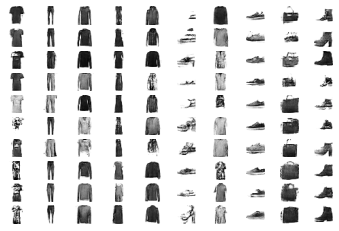

In [ ]:
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]
 
# create and save a plot of generated images
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()
 
# load model
model = load_model('cgan_generator.h5')
# generate images
latent_points, labels = generate_latent_points(100, 100)
# specify labels
labels = asarray([x for _ in range(10) for x in range(10)])
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 10)